In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
from scipy.spatial.distance import pdist, squareform
import random
import operator
import math

In [18]:
data = pd.read_csv('/content/drive/MyDrive/Hotel Reservations.csv')

In [ ]:
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [ ]:
# количество строк и столбцов
data.shape

(36275, 19)

In [19]:
# реализуем алгоритм резервуарного сэмплинга
import random
def generator(max):
    number = 1
    while number < max:
        number += 1
        yield number
# Создаём генератор потока
stream = generator(36275)
# оставим 5000 строк
k=5000
reservoir = []
for i, element in enumerate(stream):
    if i+1<= k:
        reservoir.append(element)
    else:
        probability = k/(i+1)
        if random.random() < probability:
            # Сохраняем элемент из потока, удаляя ранее добавленный 
             reservoir[random.choice(range(0,k))] = element

In [20]:
reservoir = np.array(reservoir)
data = pd.DataFrame(data, index=reservoir)

In [6]:
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
29350,INN29351,2,0,1,2,Meal Plan 1,0,Room_Type 1,62,2018,11,4,Online,0,0,0,97.2,2,Not_Canceled
30108,INN30109,2,0,2,4,Meal Plan 2,0,Room_Type 1,327,2017,9,9,Offline,0,0,0,88.0,0,Not_Canceled
32900,INN32901,2,0,2,1,Not Selected,0,Room_Type 1,205,2018,8,21,Online,0,0,0,94.5,1,Canceled
6638,INN06639,2,1,1,4,Meal Plan 1,0,Room_Type 1,73,2018,10,12,Online,0,0,0,135.0,1,Canceled
8568,INN08569,1,0,1,2,Meal Plan 1,1,Room_Type 1,11,2018,4,11,Aviation,0,0,0,104.0,0,Not_Canceled


In [ ]:
data['arrival_date'].unique()

array([13,  9, 10, 27,  5, 17, 30, 26, 23, 20, 15,  6,  4,  3, 28,  2, 22,
       19, 21, 18, 14, 11,  7, 12, 16, 24, 25, 29,  8,  1, 31])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 29350 to 34990
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            5000 non-null   object 
 1   no_of_adults                          5000 non-null   int64  
 2   no_of_children                        5000 non-null   int64  
 3   no_of_weekend_nights                  5000 non-null   int64  
 4   no_of_week_nights                     5000 non-null   int64  
 5   type_of_meal_plan                     5000 non-null   object 
 6   required_car_parking_space            5000 non-null   int64  
 7   room_type_reserved                    5000 non-null   object 
 8   lead_time                             5000 non-null   int64  
 9   arrival_year                          5000 non-null   int64  
 10  arrival_month                         5000 non-null   int64  
 11  arrival_date

In [21]:
# удаление пустых значений
data = data.dropna()

In [ ]:
data['type_of_meal_plan'].unique()

array(['Meal Plan 2', 'Meal Plan 1', 'Not Selected'], dtype=object)

In [22]:
data['type_of_meal_plan'] = data['type_of_meal_plan'].map({'Meal Plan 1': 0,
                                                           'Not Selected': 3,
                                                           'Meal Plan 2': 1,
                                                           'Meal Plan 3': 2})

In [ ]:
data['room_type_reserved'].unique()

array(['Room_Type 1', 'Room_Type 4', 'Room_Type 6', 'Room_Type 5',
       'Room_Type 2', 'Room_Type 7'], dtype=object)

In [23]:
data['room_type_reserved'] = data['room_type_reserved'].map({'Room_Type 1': 0,
                                                           'Room_Type 2': 1,
                                                           'Room_Type 3': 2,
                                                           'Room_Type 4': 3,
                                                           'Room_Type 5': 4,
                                                           'Room_Type 6': 5,
                                                           'Room_Type 7': 6})

In [ ]:
data['market_segment_type'].unique()

array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
      dtype=object)

In [24]:
data['market_segment_type'] = data['market_segment_type'].map({'Offline': 0,
                                                           'Online': 1,
                                                           'Corporate': 2,
                                                           'Aviation': 3,
                                                           'Complementary': 4})

In [25]:
''' исключим первую и последную колонку Booking_ID и booking_status типа object,
которые точно не будут использованы в анализе'''
data.drop(axis=1, columns=['Booking_ID', 'booking_status'], inplace=True)

In [26]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
21859,1,0,2,3,0,0,0,24,2018,8,19,0,0,0,0,70.00,0
32952,2,0,0,1,3,0,0,126,2018,5,7,1,0,0,0,103.50,0
20603,1,0,0,1,3,0,0,18,2018,9,15,1,0,0,0,139.00,1
26879,2,0,0,2,0,0,0,90,2018,4,1,1,0,0,0,63.86,1
6,2,0,1,3,0,0,0,34,2017,10,15,1,0,0,0,107.55,1


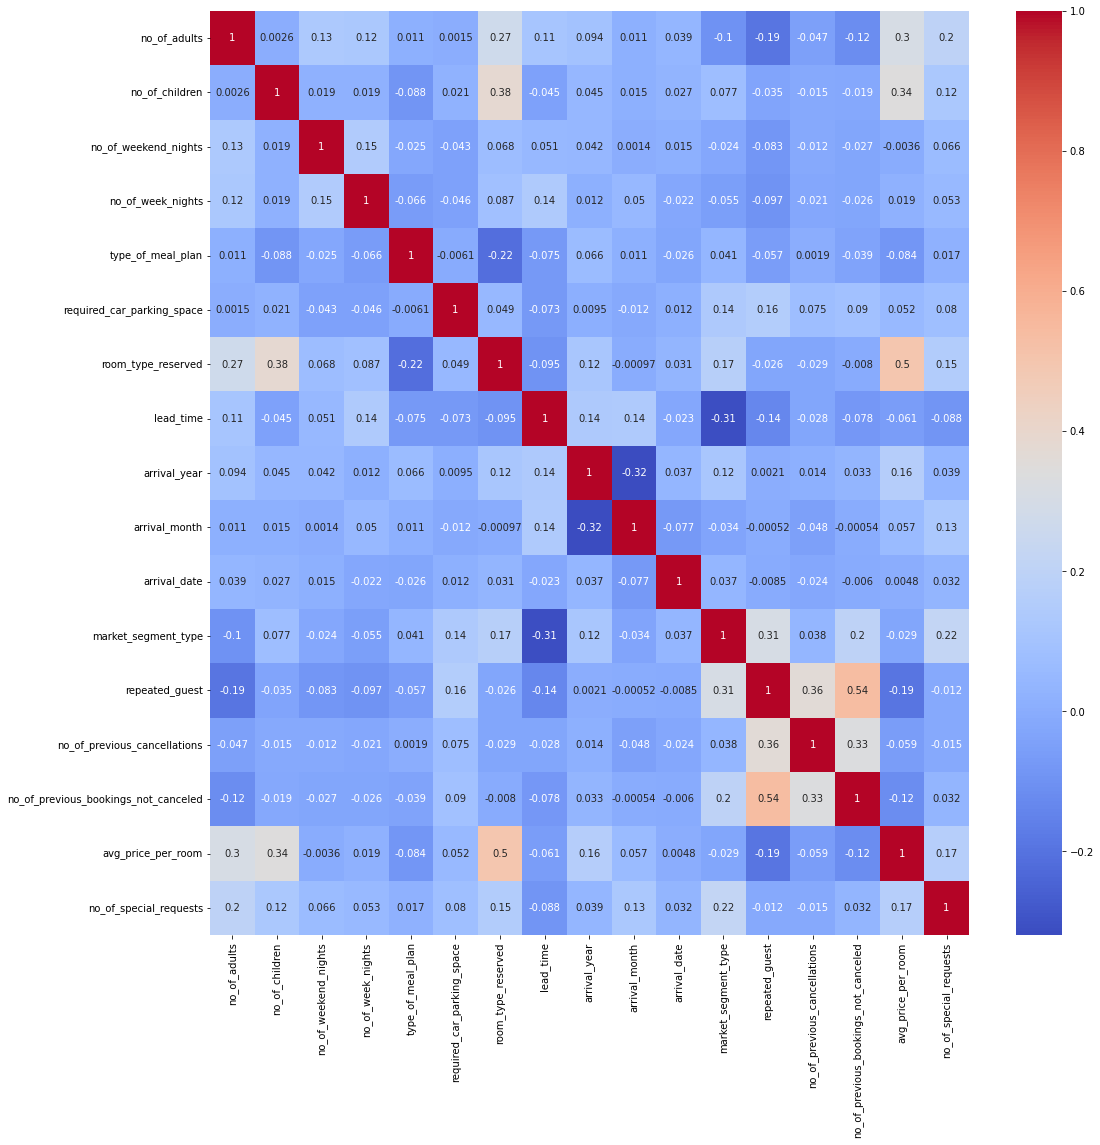

In [ ]:
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(data.corr(), annot=True, ax=ax, cmap='coolwarm')
plt.show()

In [27]:
data = data[['no_of_adults', 'no_of_children', 'type_of_meal_plan',
             'required_car_parking_space', 'arrival_month',
             'market_segment_type']]
data.to_csv('/content/drive/MyDrive/Hotel Reservations_2.csv', index=False)

In [28]:
data

,no_of_adults,no_of_children,type_of_meal_plan,required_car_parking_space,arrival_month,market_segment_type
21859,1,0,0,0,8,0
32952,2,0,3,0,5,1
20603,1,0,3,0,9,1
26879,2,0,0,0,4,1
6,2,0,0,0,10,1
...,...,...,...,...,...,...
12160,2,0,0,0,9,0
25358,2,1,0,0,6,1
31655,2,0,0,0,8,1
15259,1,0,0,0,11,0


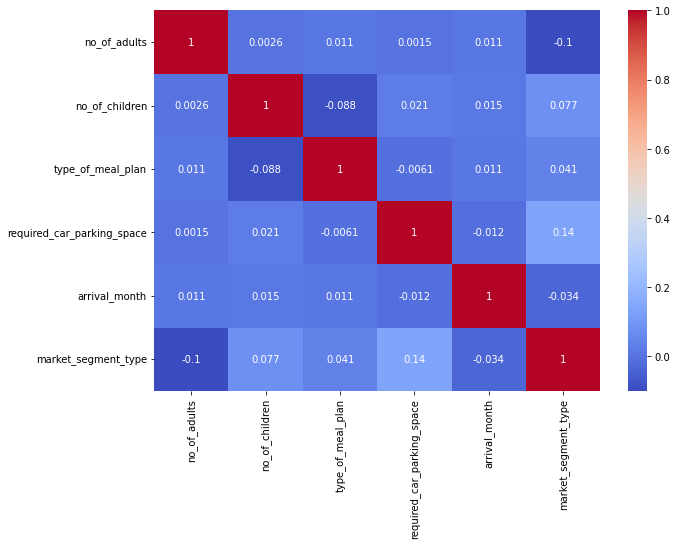

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(data.corr(), annot=True, ax=ax, cmap='coolwarm')
plt.show()

<Axes: xlabel='no_of_adults', ylabel='count'>

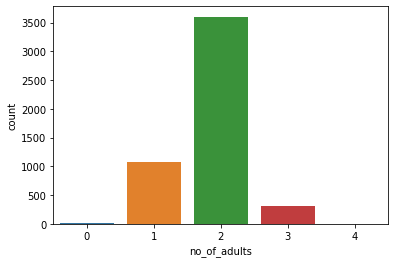

In [ ]:
sns.countplot(data, x='no_of_adults')

<Axes: xlabel='no_of_children', ylabel='count'>

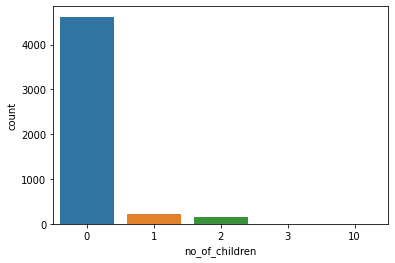

In [ ]:
sns.countplot(data, x='no_of_children')

<Axes: xlabel='market_segment_type', ylabel='count'>

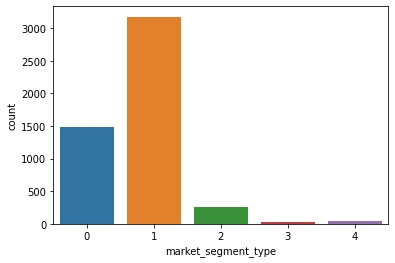

In [ ]:
sns.countplot(data, x='market_segment_type')

<Axes: xlabel='type_of_meal_plan', ylabel='count'>

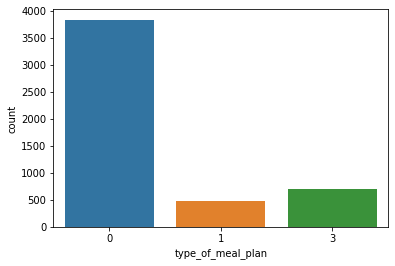

In [ ]:
sns.countplot(data, x='type_of_meal_plan')

<Axes: xlabel='required_car_parking_space', ylabel='count'>

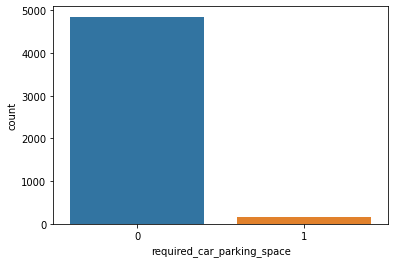

In [ ]:
sns.countplot(data, x='required_car_parking_space')

<Axes: xlabel='arrival_month', ylabel='count'>

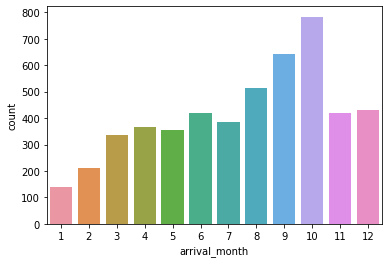

In [ ]:
sns.countplot(data, x='arrival_month')

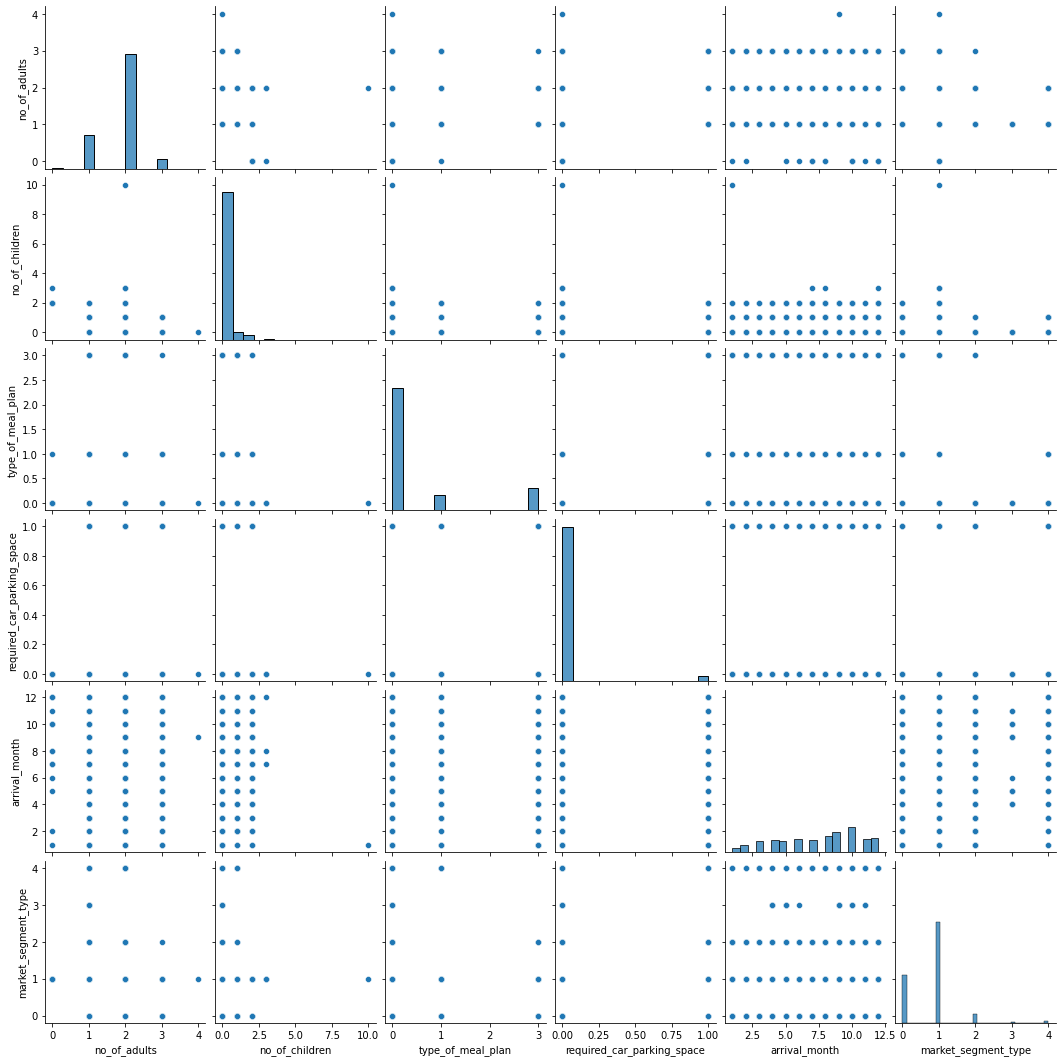

In [ ]:
sns.pairplot(data)

In [30]:
#нормализуем данные
scaler = preprocessing.MinMaxScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [31]:
data_norm.head()

,no_of_adults,no_of_children,type_of_meal_plan,required_car_parking_space,arrival_month,market_segment_type
0,0.333333,0.0,0.0,0.0,0.636364,0.00
1,0.666667,0.0,1.0,0.0,0.363636,0.25
2,0.333333,0.0,1.0,0.0,0.727273,0.25
3,0.666667,0.0,0.0,0.0,0.272727,0.25
4,0.666667,0.0,0.0,0.0,0.818182,0.25


In [32]:
matrix = pd.DataFrame(squareform(pdist(data_norm, metric='euclidean')))
matrix

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.000000,1.117135,1.034777,0.553030,0.454609,0.493298,0.762446,0.497987,0.426469,0.441284,...,1.087141,0.440705,0.545455,0.497987,0.569544,0.345508,0.467990,0.416667,0.272727,0.762446
1,1.117135,0.000000,0.493298,1.004124,1.098459,1.034777,1.054093,1.000000,1.016395,1.058005,...,1.460216,1.069849,1.117135,1.139088,1.083333,1.093038,1.010253,1.036523,1.212902,1.054093
2,1.034777,0.493298,0.000000,1.147921,1.058005,1.174829,1.255658,1.115053,1.069658,1.098459,...,1.452966,1.059932,1.211387,1.069658,1.093038,1.083333,1.094457,1.058005,1.046689,1.255658
3,0.553030,1.004124,1.147921,0.000000,0.545455,0.250000,0.345508,0.090909,0.272727,0.333333,...,1.098459,0.467929,0.454609,0.636364,0.426469,0.518760,0.213081,0.363636,0.760638,0.345508
4,0.454609,1.098459,1.058005,0.545455,0.000000,0.600017,0.563669,0.454545,0.272727,0.639243,...,1.004124,0.143562,0.838175,0.090909,0.616622,0.266016,0.380233,0.181818,0.426469,0.563669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.345508,1.093038,1.083333,0.518760,0.266016,0.454545,0.553030,0.441284,0.309124,0.616622,...,1.030776,0.273579,0.718380,0.309124,0.702383,0.000000,0.386298,0.266016,0.379696,0.553030
4996,0.467990,1.010253,1.094457,0.213081,0.380233,0.328487,0.362934,0.143562,0.143562,0.395619,...,1.042461,0.272727,0.564082,0.467929,0.440705,0.386298,0.000000,0.213081,0.626553,0.362934
4997,0.416667,1.036523,1.058005,0.363636,0.181818,0.441284,0.430687,0.272727,0.090909,0.493298,...,1.004124,0.143562,0.686390,0.272727,0.497987,0.266016,0.213081,0.000000,0.497987,0.430687
4998,0.272727,1.212902,1.046689,0.760638,0.426469,0.718380,0.896920,0.686390,0.553030,0.683709,...,1.098485,0.467990,0.818182,0.416667,0.739946,0.379696,0.626553,0.497987,0.000000,0.896920


In [33]:
WCSS = []

for n_cluster in range(2, 15):
    kmeans = KMeans(n_clusters=n_cluster, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(data_norm)
    WCSS.append(kmeans.inertia_)

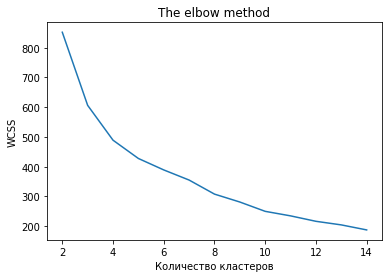

In [34]:
plt.plot(range(2, 15), WCSS)
plt.title('The elbow method')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

In [65]:
n = len(data_norm)
k = 4 # количество кластеров
m = 1.7 # фаззификатор

In [66]:
def initializeMembershipMatrix(): # рассчитаем матрицу принадлежности элементов к кластерам
    membership_mat = []
    for i in range(n):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        
        flag = temp_list.index(max(temp_list))
        for j in range(0,len(temp_list)):
            if(j == flag):
                temp_list[j] = 1
            else:
                temp_list[j] = 0
        
        membership_mat.append(temp_list)
    return membership_mat

In [67]:
membership_mat = initializeMembershipMatrix()

In [68]:
def calculateClusterCenter(membership_mat): # рассчитаем центры кластеров
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        xraised = [p ** m for p in x]
        denominator = sum(xraised)
        temp_num = []
        for i in range(n):
            data_point = list(data_norm.iloc[i])
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, list(zip(*temp_num)))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

In [78]:
calculateClusterCenter(membership_mat)

[[0.6204004329004299,
  0.009650072150072138,
  0.1758658008658011,
  0.027597402597402596,
  0.5781434474616316,
  0.1992694805194805,
  1.7702922077922079],
 [0.6167050986420655,
  0.012042018959774508,
  0.1770433000256216,
  0.02997694081475788,
  0.591922297533367,
  0.19792467332820907,
  1.7770945426594926],
 [0.6080645161290295,
  0.012365591397849438,
  0.17956989247311858,
  0.03064516129032258,
  0.5907624633431106,
  0.19858870967741934,
  1.7798387096774193],
 [0.6098886172235763,
  0.014851036855926801,
  0.1784841075794623,
  0.027709861450692746,
  0.5860561606282897,
  0.20823145884270577,
  1.7530562347188263]]

In [70]:
def updateMembershipValue(membership_mat, cluster_centers): # обновим матрицу принадлежности
    p = float(2/(m-1))
    for i in range(n):
        x = list(data_norm.iloc[i])
        distances = [np.linalg.norm(np.array(list(map(operator.sub, x, cluster_centers[j])))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat

In [71]:
def getClusters(membership_mat): # вывести лэйблы кластеров
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

In [72]:
def fuzzyCMeansClustering():
    '''Реализуем Метод нечёткой кластеризации C-средних
    с центрами кластеров в случайных местах в многомерном гауссовском распределении с нулевым средним и единичной дисперсией
    '''
    membership_mat = initializeMembershipMatrix()
    curr = 0
    acc=[]
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    
    lis1,cent_temp=[],[]
    
    for i in range(0,k):
        Z = list(np.random.multivariate_normal(mean, cov))
        Z1 = list(np.random.multivariate_normal(mean, cov))
        lis1 = Z+Z1
        cent_temp.append(lis1)
       
    while curr < 100:
        if(curr == 0):
            cluster_centers = cent_temp
            print("Cluster Centers:")
            print(np.array(cluster_centers))
        else:
            cluster_centers = calculateClusterCenter(membership_mat)
        #cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        acc.append(cluster_labels)
        curr += 1
    print("---------------------------")
    print("Membership Matrix:")
    print(np.array(membership_mat))
    return cluster_labels, cluster_centers, acc

In [73]:
labels, centers, acc = fuzzyCMeansClustering()

Cluster Centers:
[[ 0.09273539 -0.81008495  1.3078383  -1.53294589]
 [ 0.95174937  0.84729263 -1.6008808  -0.82264243]
 [ 0.12895113  0.50858112  0.78173057 -0.84499316]
 [ 1.05555855  0.52836452 -0.18967569 -0.11513799]]
---------------------------
Membership Matrix:
[[2.22244892e-02 1.71582789e-01 4.32249986e-01 3.73942736e-01]
 [9.58056306e-01 1.53578527e-02 1.49547237e-02 1.16311177e-02]
 [9.01094323e-01 2.72510382e-02 3.61237753e-02 3.55308636e-02]
 ...
 [5.29526576e-04 7.44841231e-03 9.57362075e-01 3.46599857e-02]
 [2.30981288e-02 7.16153615e-02 2.51119095e-01 6.54167414e-01]
 [2.92932052e-02 4.66457738e-01 3.62211291e-01 1.42037765e-01]]


In [74]:
data_norm['labels'] = labels

In [75]:
data_norm['labels'].unique()

array([2, 0, 1, 3])

In [76]:
data_norm.head()

,no_of_adults,no_of_children,type_of_meal_plan,required_car_parking_space,arrival_month,market_segment_type,labels
0,0.333333,0.0,0.0,0.0,0.636364,0.00,2
1,0.666667,0.0,1.0,0.0,0.363636,0.25,0
2,0.333333,0.0,1.0,0.0,0.727273,0.25,0
3,0.666667,0.0,0.0,0.0,0.272727,0.25,1
4,0.666667,0.0,0.0,0.0,0.818182,0.25,3


In [77]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances, silhouette_score

silhouette_score(data_norm, labels, metric='euclidean')

0.6667754709224545

<Axes: xlabel='no_of_adults', ylabel='labels'>

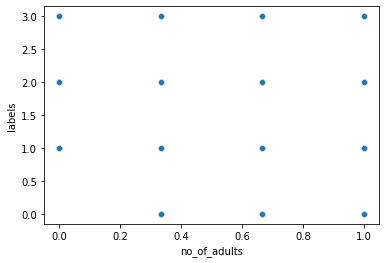

In [80]:
sns.scatterplot(data_norm, x='no_of_adults', y='labels')

<Axes: xlabel='market_segment_type', ylabel='labels'>

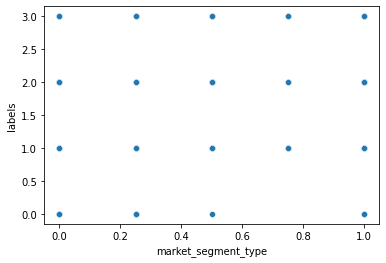

In [81]:
sns.scatterplot(data_norm, x='market_segment_type', y='labels')

<Axes: xlabel='market_segment_type', ylabel='no_of_adults'>

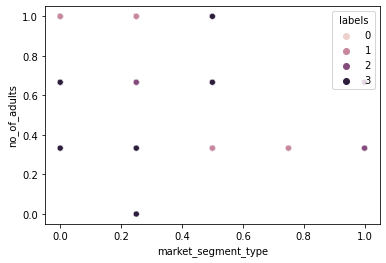

In [82]:
sns.scatterplot(data_norm, x='market_segment_type', y='no_of_adults', hue='labels')

<Axes: xlabel='no_of_adults', ylabel='no_of_children'>

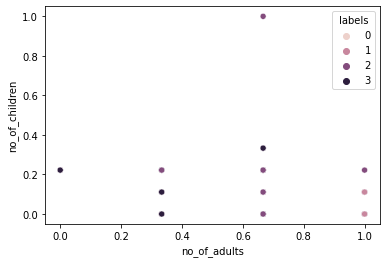

In [131]:
sns.scatterplot(data_norm, x='no_of_adults', y='no_of_children', hue='labels')

In [84]:
data['labels'] = labels
data.head()

,no_of_adults,no_of_children,type_of_meal_plan,required_car_parking_space,arrival_month,market_segment_type,labels
21859,1,0,0,0,8,0,2
32952,2,0,3,0,5,1,0
20603,1,0,3,0,9,1,0
26879,2,0,0,0,4,1,1
6,2,0,0,0,10,1,3


In [93]:
label_0 = data[data['labels'] == 0]
label_0['no_of_adults'].value_counts()

2    647
1     86
3      5
Name: no_of_adults, dtype: int64

In [130]:
label_0 = data[data['labels'] == 1]
label_0['no_of_adults'].value_counts()

2    819
1    371
3     76
0      5
Name: no_of_adults, dtype: int64

In [95]:
label_2 = data[data['labels'] == 2]
label_2['no_of_adults'].value_counts()

2    1082
1     177
3     129
0       5
Name: no_of_adults, dtype: int64

In [96]:
label_3 = data[data['labels'] == 3]
label_3['no_of_adults'].value_counts()

2    1095
1     420
3      79
0       4
Name: no_of_adults, dtype: int64